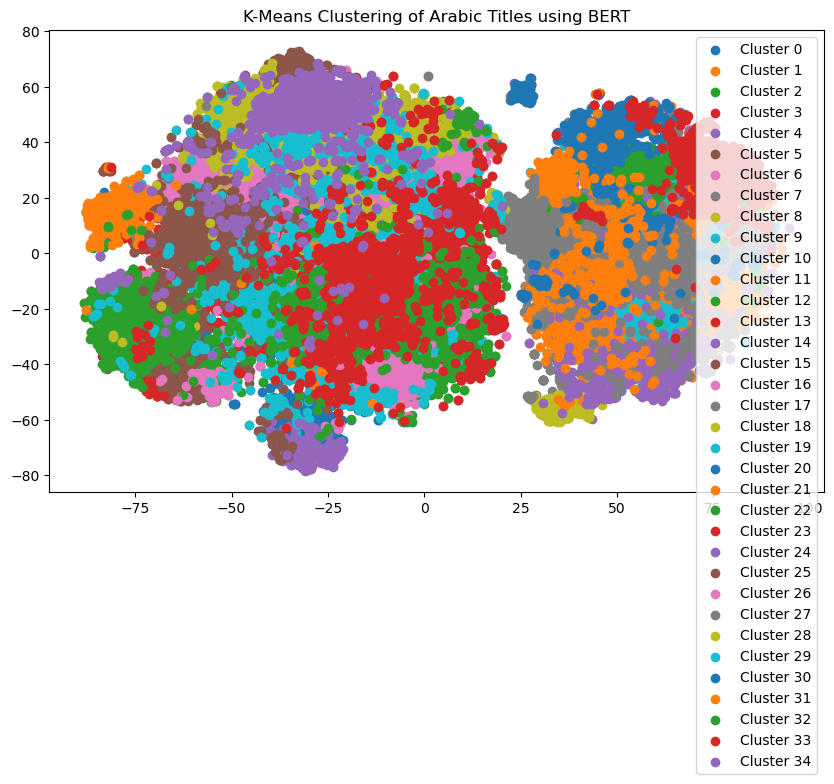

Cluster 0 Sample Titles:
['بعد انهيار حلب .. السوداني يهاتف الأسد وتعزيزات عراقية على حدود سوريا', 'وزيرا الجيوش والخارجية الفرنسيان في بيروت لدعم الجيش اللبناني وسط هدنة هشة\xa0بين حزب الله وإسرائيل', 'وزير الخارجية العراقي يتوقع بقاء القوات الأميركية في بلاده', 'مئات المحتجين يقتحمون محكمة كورية جنوبية بعد قرار تمديد حبس الرئيس المعزول يون سوك يول', 'الكنيست الإسرائيلي يتبنى مشروع قرار يرفض إقامة "دولة فلسطينية"']
---
Cluster 1 Sample Titles:
['دبيبة يخشى من تحول ليبيا إلى مسرح للصراعات الدولية بعد أنباء عن نقل أسلحة روسية من سوريا', 'بوادر خلاف أميركي تركي تلوح في أفق الشمال السوري', 'واشنطن ستكمل سحب قواتها من القاعدة الجوية 101 في النيجر الأحد', 'دولتان وربما الأردن.. وفد أميركي كبير إلى الشرق الأوسط', 'إنذار جوي في أوكرانيا بسبب خطر صواريخ بالستية روسية']
---
Cluster 2 Sample Titles:
['ذكرى وفاة مهسا أميني.. عامان من الغضب والقمع والتحدي', 'مقتل قائد قطاع وسط دارفور علي يعقوب جبريل من قوات الدعم السريع في الفاشر', 'هيئة البث الإسرائيلية: محادثات الهدنة وصلت لطريق مسدود', 'عبد الم

In [65]:
import pandas as pd
import re
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load the dataset
file_path = "full_data_fusionne.csv"  # Change this if needed
df = pd.read_csv(file_path)

# Preprocessing function for Arabic text
def clean_arabic_text(text):
    text = text.lower()
    text = re.sub(r'[\u064B-\u0652]', '', text)  # Remove diacritics
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # Keep only Arabic letters
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")
    text = text.replace("ة", "ه").replace("ي", "ى")
    return text.strip()

# Apply cleaning to the title column
df["clean_title"] = df["title"].apply(clean_arabic_text)

# Remove duplicate titles
df = df.drop_duplicates(subset=["clean_title"])

# Load Arabic BERT model
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Compute embeddings
embeddings = np.array([get_bert_embedding(text) for text in df["clean_title"]])

# Apply K-Means Clustering
num_clusters = 35  # Change this as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(embeddings)

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_points = reduced_embeddings[df["cluster"] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}")
plt.legend()
plt.title("K-Means Clustering of Arabic Titles using BERT")
plt.show()

# Display sample titles per cluster
for i in range(num_clusters):
    print(f"Cluster {i} Sample Titles:")
    print(df[df["cluster"] == i]["title"].sample(5, random_state=42).tolist())
    print("---")


In [67]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Compute silhouette score
silhouette_avg = silhouette_score(embeddings, df["cluster"])

# Compute Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(embeddings, df["cluster"])

# Compute Inertia (WCSS)
inertia = kmeans.inertia_

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Inertia (WCSS): {inertia:.4f}")


Silhouette Score: 0.0327
Calinski-Harabasz Index: 1809.0764
Inertia (WCSS): 2664552.7500


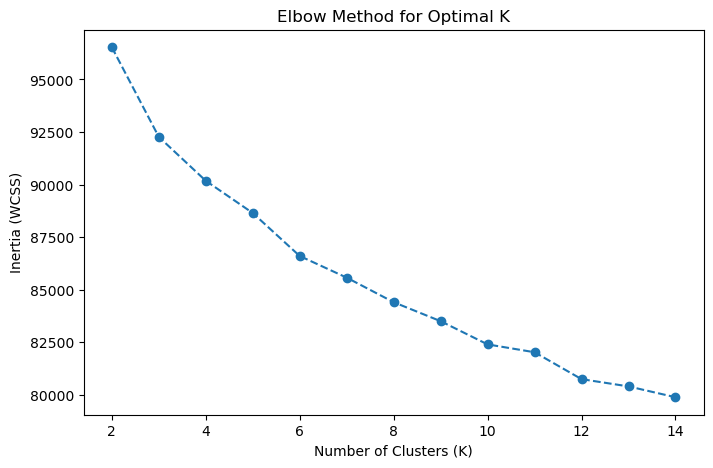

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_range = range(35, 40)  # Testing K values from 2 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()


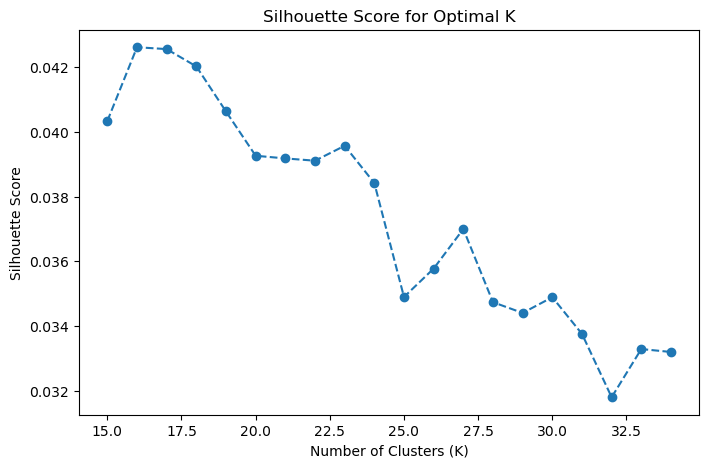

0.042610988


In [71]:
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(15, 35)  # Testing K values from 2 to 14
max_k=0
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    sil_scores.append(silhouette_score(embeddings, labels))
    if silhouette_score(embeddings, labels) >= max(sil_scores):
        max_k=k

plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()
print(max(sil_scores),max_k)
# kmeans = KMeans(n_clusters=35, random_state=42, n_init=10)
# labels = kmeans.fit_predict(embeddings)
# print(silhouette_score(embeddings, labels))


16